## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

## Load data
The dataset is the Heart Disease Data Set from UCI Machine Learning Repository. It is a binary classifiation dataset, the label is stored in `target` column. **Please note that there exist categorical features which need to be [one-hot encoding](https://www.datacamp.com/community/tutorials/categorical-data) before fit into your model!**
See follow links for more information
https://archive.ics.uci.edu/ml/datasets/heart+Disease

In [1]:
import pandas as pd
import numpy as np
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

# find noise
# noise_list = []
# for i in range(df.shape[0]):
#     if df['thal'][i] == '1' or df['thal'][i] == '2':
#         noise_list.append(i)
# print ('noise index: ', noise_list)
# df = df.drop(noise_list)

# # one-hot encoding
# df_ohe = df.copy()
# df_ohe = pd.get_dummies(df_ohe, columns=['thal'], prefix = ['thal'])
# df_ohe.head()

# # change the order (move target to last)
# df_ohe_target = df_ohe['target']
# df_ohe = df_ohe.drop(['target'], axis = 1)
# df_ohe = df_ohe.assign(target=df_ohe_target)
# df_ohe.head()

In [2]:
train_idx = np.load('train_idx.npy')
test_idx = np.load('test_idx.npy')
# train_idx = np.setdiff1d(train_idx, noise_list)  # delete noise
# test_idx = np.setdiff1d(test_idx, noise_list)    # delete noise

train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

# one-hot encoding
train_df_ohe = train_df.copy()
train_df_ohe = pd.get_dummies(train_df_ohe, columns=['thal'], prefix = ['thal'])
test_df_ohe = test_df.copy()
test_df_ohe = pd.get_dummies(test_df_ohe, columns=['thal'], prefix = ['thal'])

# change the order (move target to last)
train_df_ohe_target = train_df_ohe['target']
train_df_ohe = train_df_ohe.drop(['target'], axis = 1)
train_df_ohe = train_df_ohe.assign(target=train_df_ohe_target)
test_df_ohe_target = test_df_ohe['target']
test_df_ohe = test_df_ohe.drop(['target'], axis = 1)
test_df_ohe = test_df_ohe.assign(target=test_df_ohe_target)

In [3]:
train_df_ohe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal_fixed,thal_normal,thal_reversible,target
136,54,1,2,192,283,0,2,195,0,0.0,1,1,0,0,1,0
232,58,0,4,170,225,1,2,146,1,2.8,2,2,1,0,0,1
233,56,1,2,130,221,0,2,163,0,0.0,1,0,0,0,1,0
184,46,1,4,120,249,0,2,144,0,0.8,1,0,0,0,1,0
84,55,0,2,135,250,0,2,161,0,1.4,2,0,0,1,0,0


In [4]:
X_train = train_df_ohe.iloc[:,:-1].values
y_train = train_df_ohe.iloc[:,-1:].values
X_test = test_df_ohe.iloc[:,:-1].values
y_test = test_df_ohe.iloc[:,-1:].values
X_train

array([[54.,  1.,  2., ...,  0.,  0.,  1.],
       [58.,  0.,  4., ...,  1.,  0.,  0.],
       [56.,  1.,  2., ...,  0.,  0.,  1.],
       ...,
       [64.,  1.,  1., ...,  0.,  0.,  1.],
       [44.,  1.,  3., ...,  0.,  1.,  0.],
       [57.,  1.,  3., ...,  0.,  1.,  0.]])

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [5]:
def gini(sequence):
    _, cnt = np.unique(sequence, return_counts=True)
    prob = cnt / sequence.shape[0]
    g = 1 - np.sum([p**2 for p in prob])
    return g


def entropy(sequence):
    _, cnt = np.unique(sequence, return_counts=True)
    prob = cnt / sequence.shape[0]
    e = -1 * np.sum([p*np.log2(p) for p in prob])
    return e

In [6]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [7]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [8]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [9]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        self.criterion = criterion  # Setting the evaluation function (gini / entropy)
        if criterion == 'gini':
            self.measure_func = gini
        else:
            self.measure_func = entropy
        self.max_depth = max_depth  # Setting the max depth of the tree
        self.root = None
        self.total_fi = None
        return None

    class Node():
        def __init__(self):
            self.feature = None
            self.thres = None
            self.impurity = None
            self.data_num = None
            self.left = None
            self.right = None
            self.predict_class = None

    def get_thres(self, data):
        thres = None
        feature = None
        split = False
        min_impurity = None
        impurity_in = self.measure_func(data[:, -1].astype(np.int32))
        info_gain = 0
        (n, dim) = data.shape
        dim -= 1
        for i in range(dim):
            data_sorted = np.asarray(sorted(data, key=lambda t: t[i]))
            for j in range(1, n):
                t = (data_sorted[j - 1, i] + data_sorted[j, i]) / 2
                left_data = data_sorted[data_sorted[:, i] < t]
                right_data = data_sorted[data_sorted[:, i] >= t]
                left_impurity = self.measure_func(left_data[:, -1].astype(np.int32))
                right_impurity = self.measure_func(right_data[:, -1].astype(np.int32))
                impurity = left_data.shape[0] * left_impurity
                impurity += right_data.shape[0] * right_impurity
                impurity /= data_sorted.shape[0]
                if impurity_in - impurity > info_gain:
                    split = True
                    min_impurity = impurity
                    thres = t
                    feature = i
                    info_gain = impurity_in - impurity
        return split, feature, thres, min_impurity

    def build_tree(self, data, depth=None):
        node = self.Node()
        ## --- check the X element are the same ---
        checkSame = []
        for i in range(data.shape[0] - 1):
            if (data[i][:-1] == data[i+1][:-1]).all():
                checkSame.append(True)
            else:
                checkSame.append(False)
        ## ---------------- end -------------------
        if self.measure_func(data[:, -1].astype(np.int32)) == 0:  # check impurity = 0
            node.predict_class = int(data[0, -1])
        elif len(data) == 0:                                      # check no element in a leaf
            node.predict_class = 0
        elif depth == 0:                                          # check depth = 0
            label, cnt = np.unique(data[:, -1].astype(np.int32), return_counts=True)
            node.predict_class = label[np.argmax(cnt)]
        elif all(checkSame) == True:                              # check the same X element
            label, cnt = np.unique(data[:, -1].astype(np.int32), return_counts=True)
            node.predict_class = label[np.argmax(cnt)]
        else:
            split, feature, thres, impurity = self.get_thres(data)
            if split == True:
                node.feature = feature
                node.thres = thres
                node.impurity = impurity
                node.data_num = data.shape[0]
                left_data = data[data[:, feature] < thres]
                right_data = data[data[:, feature] >= thres]
                if depth is None:
                    node.left = self.build_tree(left_data)
                    node.right = self.build_tree(right_data)
                else:
                    node.left = self.build_tree(left_data, depth-1)
                    node.right = self.build_tree(right_data, depth-1)
            else:
                label, cnt = np.unique(data[:, -1].astype(np.int32), return_counts=True)
                node.predict_class = label[np.argmax(cnt)]
        return node

    def train(self, X, y):
        data = np.hstack((X, y))
        self.root = self.build_tree(data, self.max_depth)

    def traverse(self, node, X):
        if node.predict_class is not None:
            return node.predict_class
        else:
            if X[node.feature] < node.thres:
                return self.traverse(node.left, X)
            else:
                return self.traverse(node.right, X)

    def print_acc(self, acc):
        print(f'criterion = {self.criterion}')
        print(f'max depth = {self.max_depth}')
        print(f'acc       = {acc}')
        print('====================')

    def predict(self, X, y=None):
        pred = np.zeros(X.shape[0]).astype(np.int32)
        correct = 0
        for i in range(X.shape[0]):
            pred[i] = self.traverse(self.root, X[i])
            if y is not None:
                if pred[i] == y[i, 0]:
                    correct += 1
        acc = correct / X.shape[0] if y is not None else None
        self.print_acc(acc)
        return pred, acc

    def get_fi(self, node):
        if node.left and node.left.impurity is not None:
            self.get_fi(node.left)
        if node.right and node.right.impurity is not None:
            self.get_fi(node.right)
        self.total_fi[node.feature] += 1

    def feature_importance(self):
        self.total_fi = np.zeros(len(feature_names))
        self.get_fi(self.root)
        return self.total_fi

    def print_tree(self, node, ident):
        if node.predict_class is not None:
            print(f'{ident}Predict {node.predict_class}')
        else:
            print(f'{ident}{node.feature} >= {node.thres}')
            print(f'{ident}--> True:')
            self.print_tree(node.right, ident + '  ')
            print(f'{ident}--> False:')
            self.print_tree(node.left, ident + '  ')

### Question 2.1
Using `criterion=gini`, showing the accuracy score of test data by `max_depth=3` and `max_depth=10`, respectively.


In [10]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.train(X_train, y_train)
_, acc = clf_depth3.predict(X_test, y_test)

clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.train(X_train, y_train)
_, acc = clf_depth10.predict(X_test, y_test)

criterion = gini
max depth = 3
acc       = 0.79
criterion = gini
max depth = 10
acc       = 0.73


### Question 2.2
Using `max_depth=3`, showing the accuracy score of test data by `criterion=gini` and `criterion=entropy`, respectively.


In [11]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.train(X_train, y_train)
_, acc = clf_gini.predict(X_test, y_test)

clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.train(X_train, y_train)
_, acc = clf_entropy.predict(X_test, y_test)

criterion = gini
max depth = 3
acc       = 0.79
criterion = entropy
max depth = 3
acc       = 0.76


- Note: Your decisition tree scores should over **0.7**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

In [12]:
feature_names = train_df_ohe.columns
feature_names = feature_names.drop(['target'])
feature_names

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal_fixed', 'thal_normal',
       'thal_reversible'],
      dtype='object')

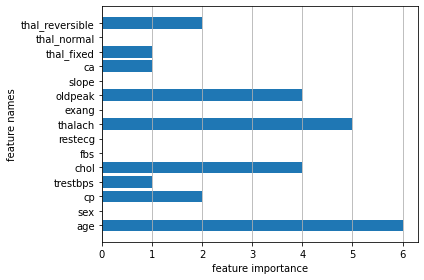

In [13]:
import matplotlib.pyplot as plt

fi = clf_depth10.feature_importance()

x_pos = [i for i, _ in enumerate(feature_names)]
plt.barh(x_pos, fi)
plt.ylabel('feature names')
plt.xlabel('feature importance')
plt.xticks(np.arange(max(fi)+1))
plt.yticks(x_pos, feature_names)
plt.gca().grid(axis='x', which='major')
plt.tight_layout()
# plt.savefig('fi.png', dpi=300, transparent=True)
plt.show()

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [ ]:
import math
class Adaboost():
    """Boosting method that uses a number of weak classifiers in 
    ensemble to make a strong classifier. This implementation uses decision
    stumps, which is a one level Decision Tree. 
    Parameters:
    -----------
    n_clf: int
        The number of weak classifiers that will be used. 
    """
    def __init__(self, n_estimators=10):
        self.n_clf = n_estimators
        # Determines if sample shall be classified as -1 or 1 given threshold
        self.polarity = 1
        # The index of the feature used to make classification
        self.feature_index = None
        # The threshold value that the feature should be measured against
        self.threshold = None
        # Value indicative of the classifier's accuracy
        self.alpha = None

    def train(self, X, y):
        for i in range(len(y)):
            if y[i] == 0:
                y[i] = -1
        n_samples, n_features = np.shape(X)

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))
        
        self.clfs = []
        # Iterate through classifiers
        for _ in range(self.n_clf):
            # Minimum error given for using a certain feature value threshold
            # for predicting sample label
            min_error = float('inf')
            # Iterate throught every unique feature value and see what value
            # makes the best threshold for predicting y
            for feature_i in range(n_features):
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)
                # Try every unique feature value as threshold
                for threshold in unique_values:
                    p = 1
                    # Set all predictions to '1' initially
                    prediction = np.ones(np.shape(y))
                    # Label the samples whose values are below threshold as '-1'
                    prediction[X[:, feature_i] < threshold] = -1
                    # Error = sum of weights of misclassified samples
                    y = y.flatten()
                    prediction = prediction.flatten()
                    error = sum(w[y != prediction])
                    
                    # If the error is over 50% we flip the polarity so that samples that
                    # were classified as 0 are classified as 1, and vice versa
                    # E.g error = 0.8 => (1 - error) = 0.2
                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # If this threshold resulted in the smallest error we save the
                    # configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_index = feature_i
                        min_error = error
            # Calculate the alpha which is used to update the sample weights,
            # Alpha is also an approximation of this classifier's proficiency
            clf.alpha = 0.5 * math.log((1.0 - min_error) / (min_error + 1e-10))
            # Set all predictions to '1' initially
            predictions = np.ones(np.shape(y))
            # The indexes where the sample values are below threshold
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            # Label those as '-1'
            predictions[negative_idx] = -1
            # Calculate new weights 
            # Missclassified samples gets larger weights and correctly classified samples smaller
            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X, y):
        n_samples = np.shape(X)[0]
        y_pred = np.zeros((n_samples, 1))
        # For each classifier => label the samples
        for clf in self.clfs:
            # Set all predictions to '1' initially
            predictions = np.ones(np.shape(y_pred))
            # The indexes where the sample values are below threshold
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            # Label those as '-1'
            predictions[negative_idx] = -1
            # Add predictions weighted by the classifiers alpha
            # (alpha indicative of classifier's proficiency)
            y_pred += clf.alpha * predictions

        # Return sign of prediction sum
        y_pred = np.sign(y_pred).flatten()
        for i in range(len(y_pred)):
            if y_pred[i] == -1:
                y_pred[i] = 0
        
        correct = 0
        for i in range(len(y_pred)):
            if y[i]==y_pred[i]:
                correct += 1
        acc = correct / len(y_pred)
        return y_pred, acc

### Question 4.1
Show the accuracy score of test data by `n_estimators=10` and `n_estimators=100`, respectively.


In [ ]:
clf_Adaboost = Adaboost(n_estimators=10)
clf_Adaboost.train(X_train, y_train)
y_pred, acc = clf_Adaboost.predict(X_test, y_test)
print(y_test.flatten())
print(y_pred)
print(acc)

## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [14]:
# import sys
# print(sys.getrecursionlimit())
# sys.setrecursionlimit(10000)

import random
random.seed(2)

class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = int(np.round(max_features))
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.clfs = []
        for i in range(self.n_estimators):
            self.clfs.append(DecisionTree(self.criterion, self.max_depth))
        self.random_vecs = []
        return None
    
    def train(self, X, y):
        for i in range(self.n_estimators):
            random_vec = random.sample(range(X.shape[1]), self.max_features)
            self.random_vecs.append(random_vec)
            if self.boostrap:
                sample_num = int(np.round(X.shape[0]*2/3))
                subset_idx = random.sample(range(X.shape[0]), sample_num)
                self.clfs[i].train(X[subset_idx][:, random_vec], y[subset_idx])
            else:
                self.clfs[i].train(X[:, random_vec], y)
            # print(f'{i+1} trees completed')

    def print_acc(self, acc):
        print(f'n estimators = {self.n_estimators}')
        print(f'max features = {self.max_features}')
        print(f'boostrap     = {self.boostrap}')
        print(f'criterion    = {self.criterion}')
        print(f'max depth    = {self.max_depth}')
        print(f'acc          = {acc}')
        print('====================')

    def predict(self, X, y=None):
        pred = np.zeros(X.shape[0]).astype(np.int32)
        correct = 0
        for i in range(X.shape[0]):
            vote = []
            for j in range(self.n_estimators):
                vote.append(self.clfs[j].traverse(self.clfs[j].root, X[i, self.random_vecs[j]]))
            label, cnt = np.unique(vote, return_counts=True)
            pred[i] = label[np.argmax(cnt)]
            if y is not None:
                if pred[i] == y[i, 0]:
                    correct += 1
        acc = correct / X.shape[0] if y is not None else None
        self.print_acc(acc)
        return pred, acc

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of test data by `n_estimators=10` and `n_estimators=100`, respectively.


In [15]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), max_depth=None)
clf_10tree.train(X_train, y_train)
_, acc = clf_10tree.predict(X_test, y_test)
    
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(X_train.shape[1]), max_depth=None)
clf_100tree.train(X_train, y_train)
_, acc = clf_100tree.predict(X_test, y_test)

n estimators = 10
max features = 4
boostrap     = True
criterion    = gini
max depth    = None
acc          = 0.81
n estimators = 100
max features = 4
boostrap     = True
criterion    = gini
max depth    = None
acc          = 0.8


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of test data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [16]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), max_depth=None)
clf_random_features.train(X_train, y_train)
_, acc = clf_random_features.predict(X_test, y_test)

clf_all_features = RandomForest(n_estimators=10, max_features=X_train.shape[1], max_depth=None)
clf_all_features.train(X_train, y_train)
_, acc = clf_all_features.predict(X_test, y_test)

n estimators = 10
max features = 4
boostrap     = True
criterion    = gini
max depth    = None
acc          = 0.8
n estimators = 10
max features = 15
boostrap     = True
criterion    = gini
max depth    = None
acc          = 0.77


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

### Question 6.
Try you best to get highest test accuracy score by 
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you cannot call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_test = test_df['target']

In [ ]:
y_pred = your_model.predict(x_test)

In [ ]:
print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 